In [1]:
import requests
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Needs fink_utils >= 0.8.2
from fink_utils.sso.spins import estimate_sso_params
from fink_utils.sso.spins import func_hg1g2_with_spin
from fink_utils.sso.spins import add_ztf_color_correction

/home/peloton/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Retrieve data from Fink with ephemerides from Miriade

In [2]:
# get data for 1465
r = requests.post(
    'https://fink-portal.org/api/v1/sso',
    json={
        'n_or_d': '1465',
        'withEphem': True,
        'output-format': 'json'
    }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [3]:
pdf.head(2)

,index,Date,LAST,HA,Az,H,Dobs,Dhelio,VMag,SDSS:g,...,i:tooflag,i:xpos,i:ypos,d:tracklet,v:classification,v:lastdate,v:firstdate,v:lapse,v:constellation,i:magpsf_red
0,0,2.459957e+06,12:43:33.85,21.236631,132.031511,29.515604,2.851332,2.488813,17.027232,17.470032,...,0,2251.8955,2209.2090,,Solar System MPC,2023-01-12 13:03:40.997,2023-01-12 13:03:40.997,0.0,Libra,12.829715
1,1,2.459938e+06,11:55:21.67,20.976368,127.809368,27.954054,3.048210,2.492563,17.083054,17.525854,...,0,2944.2190,1492.5138,,Solar System MPC,2022-12-24 13:30:18.999,2022-12-24 13:30:18.999,0.0,Libra,12.148561


## HG1G2 with spins

In [4]:
pdf = pdf.sort_values('Phase')

# Type conversion in case they turned up strings...
pdf['i:fid'] = pdf['i:fid'].apply(lambda x: int(x))

# Dictionary for filters
filters = {1: 'g', 2: 'r', 3: 'i'}
filts = np.unique(pdf['i:fid'].values)

# Input vectors
alpha = np.deg2rad(pdf['Phase'].values)
ra = np.deg2rad(pdf['i:ra'].values)
dec = np.deg2rad(pdf['i:dec'].values)
pha = np.transpose([[i, j, k] for i, j, k in zip(alpha, ra, dec)])

# Input parameters for the fit
fitfunc = func_hg1g2_with_spin
param_names = ['H', 'G1', 'G2', 'R', 'alpha[rad]', 'beta[rad]']
bounds = (
    [0, 0, 0, 1e-1, 0, -np.pi/2],
    [30, 1, 1, 1, 2*np.pi, np.pi/2]
)

### Per-band fit

In [5]:
# Add color correction in the DataFrame
pdf = add_ztf_color_correction(pdf, combined=False)

params = {}
errors = {}
chi2s = {}
for i, f in enumerate(filts):
    cond = pdf['i:fid'] == f
    
    try:
        popt, perr, chisq_red = estimate_sso_params(
            pdf.loc[cond],
            fitfunc,
            bounds=bounds
        )

        params[f] = popt
        errors[f] = perr
        chi2s[f] = chisq_red
    except RuntimeError as e:
        print("The fitting procedure could not converge.")

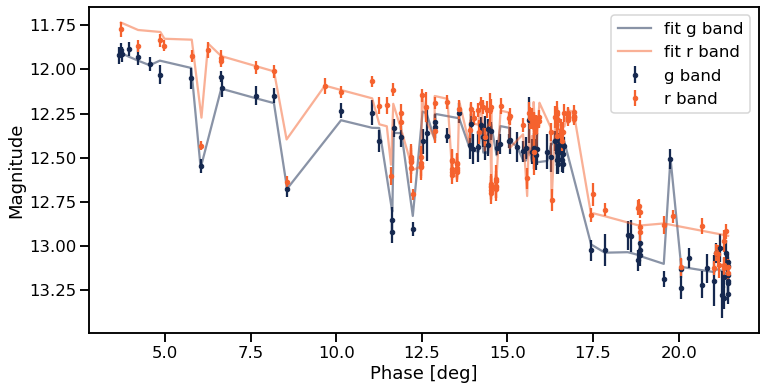

In [6]:
sns.set_context('talk')
colors = ['#15284F', '#F5622E']

fig = plt.figure(figsize=(12, 6))
for i, f in enumerate(filts):
    cond = pdf['i:fid'] == f
    ydata = pdf.loc[cond, 'i:magpsf_red'] + pdf.loc[cond, 'color_corr']
    plt.errorbar(
        pdf.loc[cond, 'Phase'].values,
        ydata.values,
        yerr=pdf.loc[cond, 'i:sigmapsf'].values,
        ls = '',
        marker='.',
        color=colors[i],
        label='{} band'.format(filters[f])
    )
    
    plt.plot(
        pdf.loc[cond, 'Phase'].values,
        func_hg1g2_with_spin(pha[:, cond], *params[f]),
        ls = '-',
        alpha=0.5,
        color=colors[i],
        label='fit {} band'.format(filters[f])
    )

plt.xlabel('Phase [deg]')
plt.ylabel('Magnitude')
fig.gca().invert_yaxis()    
plt.legend()

In [7]:
msg = """
Band: {}
params: {}
Estimates: {}
Errors: {}
Reduced $\chi^2$: {}
"""

for f in filts:
    print(
        msg.format(
            filters[f],
            param_names,
            params[f],
            errors[f],
            chi2s[f]
        )
    )


Band: g
params: ['H', 'G1', 'G2', 'R', 'alpha[rad]', 'beta[rad]']
Estimates: [11.13872636  0.48183805  0.16794537  0.4547571   2.13131953  0.18433674]
Errors: [0.24928177 0.29960203 0.08100197 0.01321032 0.02243432 0.22337446]
Reduced $\chi^2$: 1.282845363235034


Band: r
params: ['H', 'G1', 'G2', 'R', 'alpha[rad]', 'beta[rad]']
Estimates: [ 1.12551793e+01  7.91674380e-01  1.12797981e-14  5.45667185e-01
  2.25396130e+00 -2.77029693e-01]
Errors: [0.44212285 0.59746662 0.16002722 0.07494432 0.04546836 0.30104382]
Reduced $\chi^2$: 3.870876552304198



### All bands combined

In [8]:
pdf = add_ztf_color_correction(pdf, combined=True)

In [9]:
try:
    popt, perr, chisq_red = estimate_sso_params(
        pdf,
        fitfunc,
        bounds=bounds
    )
except RuntimeError as e:
    print("The fitting procedure could not converge.")

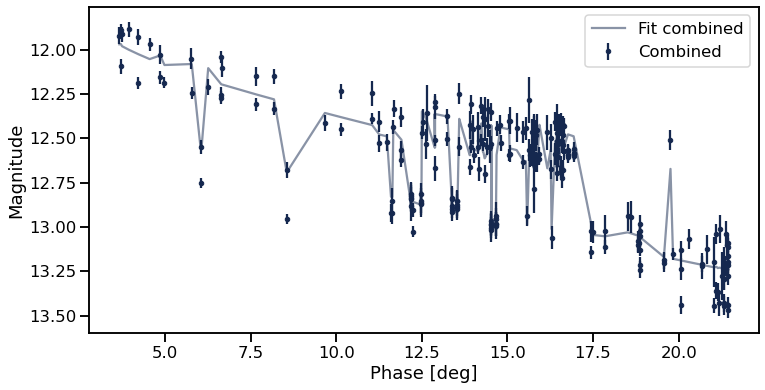

In [10]:
sns.set_context('talk')
colors = ['#15284F', '#F5622E']

fig = plt.figure(figsize=(12, 6))
ydata = pdf['i:magpsf_red'] + pdf['color_corr']
plt.errorbar(
    pdf['Phase'].values,
    ydata.values,
    yerr=pdf['i:sigmapsf'].values,
    ls = '',
    marker='.',
    color=colors[0],
    label='Combined'
)

plt.plot(
    pdf['Phase'].values,
    func_hg1g2_with_spin(pha, *popt),
    ls = '-',
    alpha=0.5,
    color=colors[0],
    label='Fit combined'
)

plt.xlabel('Phase [deg]')
plt.ylabel('Magnitude')
fig.gca().invert_yaxis()    
plt.legend()

In [11]:
msg = """
Combined
params: {}
Estimates: {}
Errors: {}
Reduced $\chi^2$: {}
"""

print(
    msg.format(
        param_names,
        popt,
        perr,
        chisq_red
    )
)


Combined
params: ['H', 'G1', 'G2', 'R', 'alpha[rad]', 'beta[rad]']
Estimates: [11.21180025  0.41081408  0.16872498  0.38096722  2.22527551  0.88976197]
Errors: [0.28738424 0.307311   0.07939017 0.09430015 0.04321891 0.18551535]
Reduced $\chi^2$: 5.877451591138056

